In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
# Define paths
data_dir = '/kaggle/input'

# Training data directory and csv path
train_img_dir = os.path.join(data_dir, 'BCN_20k_train/bcn_20k_train')
train_metadata_path = os.path.join(data_dir, 'bcn_20k_train.csv')

# Testing data directory and csv path
test_img_dir = os.path.join(data_dir, 'BCN_20k_test/bcn_20k_test')
test_metadata_path = os.path.join(data_dir, 'bcn_20k_test.csv')

# Load metadata
metadata = pd.read_csv(train_metadata_path)
print(f"Total training images: {len(metadata)}")
print(f"Total testing images: {len(pd.read_csv(test_metadata_path))}")
metadata.head()

Total training images: 12413
Total testing images: 6533


,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


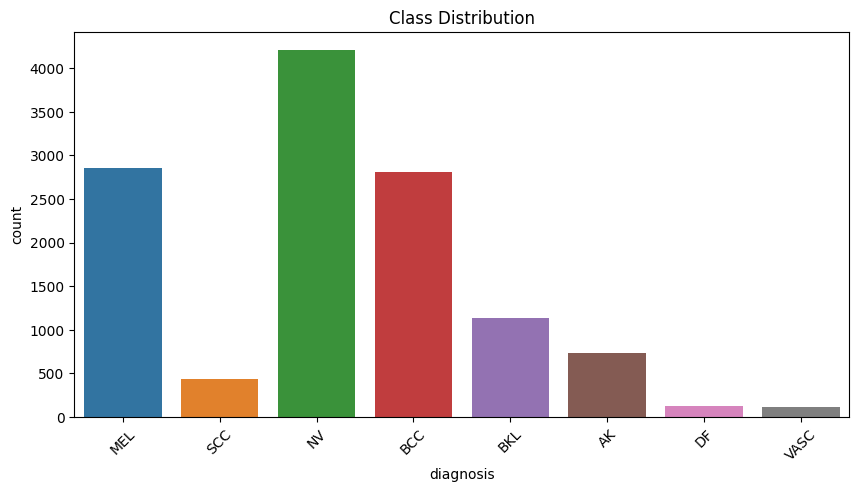

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(x='diagnosis', data=metadata)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
CLASS_MAP = {
    'AK': 0,
    'BCC': 1,
    'BKL': 2,
    'DF': 3,
    'MEL': 4,
    'NV': 5,
    'SCC': 6,
    'VASC': 7
}

In [7]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['bcn_filename']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label = CLASS_MAP[self.df.iloc[idx]['diagnosis']]  # consistent mapping
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [8]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['diagnosis'], random_state=42)

# Datasets
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=train_transforms)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
from torchvision.models import resnet50
import torch.nn as nn
import torch

class CNNOnlyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class CNNViTHybrid(nn.Module):
    def __init__(self, num_classes=8, cnn_out_channels=2048, dim=768, depth=6, heads=8, mlp_dim=1024):
        super().__init__()

        resnet = resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # (B, 2048, 7, 7)
        self.patch_embed = nn.Conv2d(cnn_out_channels, dim, kernel_size=1)  # (B, 768, 7, 7)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)                     # (B, 2048, 7, 7)
        x = self.patch_embed(x)            # (B, 768, 7, 7)
        x = x.flatten(2).transpose(1, 2)   # (B, 49, 768)
        x = self.transformer(x)            # (B, 49, 768)
        x = x.transpose(1, 2)              # (B, 768, 49)
        x = self.pool(x).squeeze(-1)       # (B, 768)
        return self.classifier(x)


In [10]:
NUM_CLASSES = len(CLASS_MAP)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate both models
cnn_model = CNNOnlyModel(num_classes=NUM_CLASSES).to(device)
hybrid_model = CNNViTHybrid(num_classes=NUM_CLASSES).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.bat

In [11]:
criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)
hybrid_optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=1e-4)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    return train_losses, val_accuracies

In [13]:
# print("Training CNN-only model:")
# cnn_train_losses, cnn_val_accs = train_model(
#     cnn_model,
#     train_loader,
#     val_loader,
#     criterion,
#     cnn_optimizer,
#     epochs=25  # Change to 25 later when ready
# )

print("\nTraining CNN + ViT hybrid model:")
vit_train_losses, vit_val_accs = train_model(
    hybrid_model,
    train_loader,
    val_loader,
    criterion,
    hybrid_optimizer,
    epochs=25
)



Training CNN + ViT hybrid model:
Epoch 1: Loss = 1.2875, Train Acc = 0.5491, Val Acc = 0.6347
Epoch 2: Loss = 1.0491, Train Acc = 0.6335, Val Acc = 0.6504
Epoch 3: Loss = 0.9496, Train Acc = 0.6665, Val Acc = 0.6971
Epoch 4: Loss = 0.8685, Train Acc = 0.6935, Val Acc = 0.7036
Epoch 5: Loss = 0.8058, Train Acc = 0.7156, Val Acc = 0.6988
Epoch 6: Loss = 0.7350, Train Acc = 0.7390, Val Acc = 0.7298
Epoch 7: Loss = 0.6798, Train Acc = 0.7631, Val Acc = 0.7370
Epoch 8: Loss = 0.6161, Train Acc = 0.7823, Val Acc = 0.7584
Epoch 9: Loss = 0.5627, Train Acc = 0.8015, Val Acc = 0.7660
Epoch 10: Loss = 0.5069, Train Acc = 0.8176, Val Acc = 0.7342
Epoch 11: Loss = 0.4757, Train Acc = 0.8312, Val Acc = 0.7857
Epoch 12: Loss = 0.4335, Train Acc = 0.8509, Val Acc = 0.7688
Epoch 13: Loss = 0.3939, Train Acc = 0.8647, Val Acc = 0.7648
Epoch 14: Loss = 0.3640, Train Acc = 0.8723, Val Acc = 0.7821
Epoch 15: Loss = 0.3528, Train Acc = 0.8794, Val Acc = 0.7853
Epoch 16: Loss = 0.3221, Train Acc = 0.8869, 

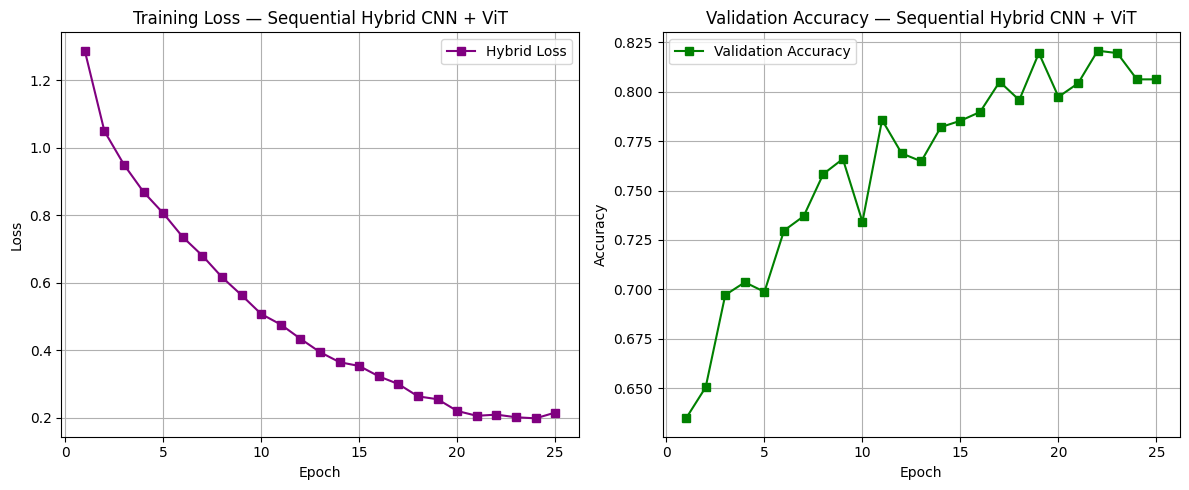

In [14]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(cnn_train_losses) + 1)

# plt.figure(figsize=(12, 5))

# # 📉 Loss Curve
# plt.subplot(1, 2, 1)
# plt.plot(epochs, cnn_train_losses, label='CNN Loss', marker='o')
# plt.plot(epochs, vit_train_losses, label='Hybrid Loss', marker='s')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Comparison')
# plt.legend()
# plt.grid(True)

# # 📈 Accuracy Curve
# plt.subplot(1, 2, 2)
# plt.plot(epochs, cnn_val_accs, label='CNN Val Acc', marker='o')
# plt.plot(epochs, vit_val_accs, label='Hybrid Val Acc', marker='s')
# plt.xlabel('Epoch')
# plt.ylabel('Validation Accuracy')
# plt.title('Validation Accuracy Comparison')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt

epochs = range(1, len(vit_train_losses) + 1)

plt.figure(figsize=(12, 5))

# 📉 Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, vit_train_losses, label='Hybrid Loss', marker='s', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss — Sequential Hybrid CNN + ViT')
plt.legend()
plt.grid(True)

# 📈 Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, vit_val_accs, label='Validation Accuracy', marker='s', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy — Sequential Hybrid CNN + ViT')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# cnn_model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = cnn_model(inputs)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# class_names = list(CLASS_MAP.keys())
# print("📋 Classification Report — CNN-only Model")
# print(classification_report(all_labels, all_preds, target_names=class_names))


In [16]:
hybrid_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = hybrid_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = list(CLASS_MAP.keys())
print("📋 Classification Report — Sequential Hybrid CNN+ViT Model")
print(classification_report(all_labels, all_preds, target_names=class_names))


📋 Classification Report — Sequential Hybrid CNN+ViT Model
              precision    recall  f1-score   support

          AK       0.71      0.54      0.61       147
         BCC       0.85      0.86      0.86       562
         BKL       0.73      0.64      0.68       228
          DF       0.81      0.52      0.63        25
         MEL       0.78      0.84      0.81       572
          NV       0.83      0.88      0.85       841
         SCC       0.70      0.58      0.64        86
        VASC       0.84      0.73      0.78        22

    accuracy                           0.81      2483
   macro avg       0.78      0.70      0.73      2483
weighted avg       0.80      0.81      0.80      2483



In [17]:
# # Evaluate CNN-only model and store predictions
# cnn_model.eval()
# cnn_preds = []
# cnn_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = cnn_model(inputs)
#         _, preds = torch.max(outputs, 1)
#         cnn_preds.extend(preds.cpu().numpy())
#         cnn_labels.extend(labels.cpu().numpy())

# # Confusion matrix
# plot_confusion_matrix(cnn_labels, cnn_preds, class_names)


In [18]:
from sklearn.metrics import confusion_matrix

def compute_sens_spec(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    for i in range(len(cm)):
        label = class_names[i] if class_names else f"Class {i}"
        print(f"{label}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

# Sensitivity and specificity
compute_sens_spec(all_labels, all_preds, class_names=list(CLASS_MAP.keys()))

Confusion Matrix:
 [[ 79  27  22   0  10   7   2   0]
 [ 12 483  11   1  12  36   5   2]
 [  8  14 145   0  20  31  10   0]
 [  0   3   0  13   4   5   0   0]
 [  5  13  12   0 478  62   1   1]
 [  2   7   6   1  84 738   3   0]
 [  5  19   3   1   3   5  50   0]
 [  0   0   0   0   4   2   0  16]]
AK: Sensitivity = 0.5374, Specificity = 0.9863
BCC: Sensitivity = 0.8594, Specificity = 0.9568
BKL: Sensitivity = 0.6360, Specificity = 0.9761
DF: Sensitivity = 0.5200, Specificity = 0.9988
MEL: Sensitivity = 0.8357, Specificity = 0.9283
NV: Sensitivity = 0.8775, Specificity = 0.9099
SCC: Sensitivity = 0.5814, Specificity = 0.9912
VASC: Sensitivity = 0.7273, Specificity = 0.9988


# Parallel Model

In [19]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, vit_b_16

class ParallelCNNViT(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        # CNN Branch: ResNet50 without classifier
        resnet = resnet50(pretrained=True)
        self.cnn_branch = nn.Sequential(*list(resnet.children())[:-1])  # (B, 2048, 1, 1)

        # ViT Branch: ViT-B/16 pretrained
        self.vit_branch = vit_b_16(pretrained=True)
        self.vit_branch.heads = nn.Identity()  # remove classifier head (output: (B, 768))

        # Freeze most of ViT and unfreeze last transformer block
        for name, param in self.vit_branch.named_parameters():
            if not any(key in name for key in ['encoder.layers.encoder_layer_11', 'heads']):
                param.requires_grad = False

        # Combined Classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # CNN feature: (B, 2048, 1, 1) → (B, 2048)
        cnn_feat = self.cnn_branch(x).squeeze(-1).squeeze(-1)

        # ViT feature: (B, 768)
        vit_feat = self.vit_branch(x)

        # Combine
        combined = torch.cat([cnn_feat, vit_feat], dim=1)  # (B, 2816)

        # Classify
        return self.classifier(combined)

In [20]:
model = ParallelCNNViT(num_classes=NUM_CLASSES).to(device)

# Loss with optional label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Only update trainable parameters
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weig

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)     

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")  

    return train_losses, val_accuracies, train_accuracies

In [22]:
parallel_train_losses, parallel_val_accs, parallel_train_accs = train_model(
    model,  # ParallelCNNViT instance
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=5
)

Epoch 1: Loss = 1.3156, Train Acc = 0.6126, Val Acc = 0.6669
Epoch 2: Loss = 1.1545, Train Acc = 0.6858, Val Acc = 0.7149
Epoch 3: Loss = 1.0630, Train Acc = 0.7251, Val Acc = 0.7322
Epoch 4: Loss = 0.9852, Train Acc = 0.7594, Val Acc = 0.7410
Epoch 5: Loss = 0.9172, Train Acc = 0.7962, Val Acc = 0.7519


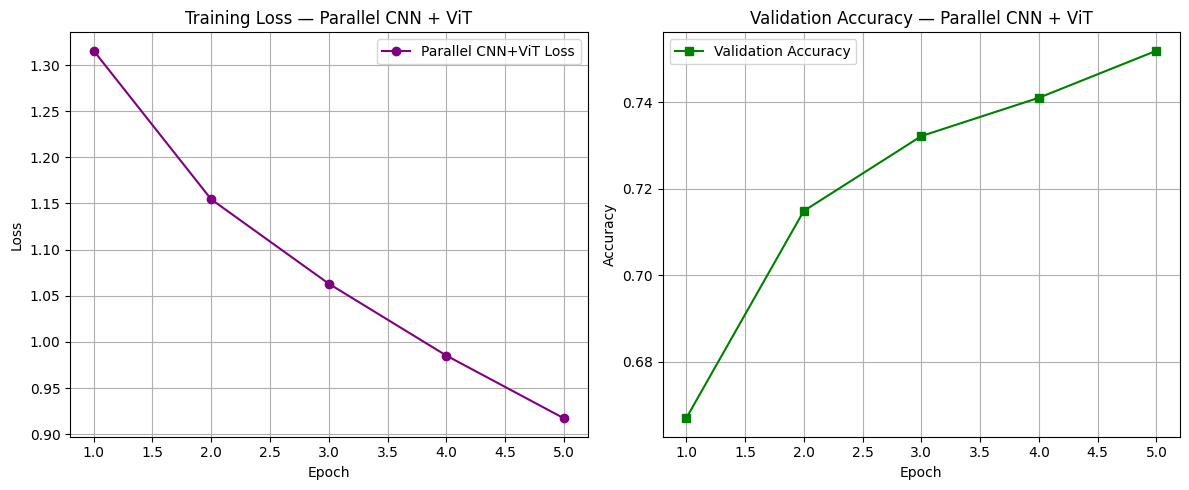

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(parallel_train_losses) + 1)

plt.figure(figsize=(12, 5))

# 📉 Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, parallel_train_losses, label='Parallel CNN+ViT Loss', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss — Parallel CNN + ViT')
plt.legend()
plt.grid(True)

# 📈 Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, parallel_val_accs, label='Validation Accuracy', marker='s', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy — Parallel CNN + ViT')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


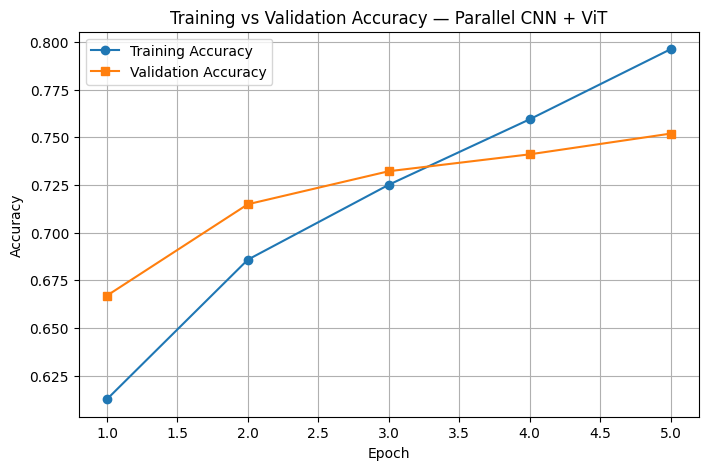

In [24]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy — Parallel CNN + ViT')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(parallel_train_accs, parallel_val_accs)

Fine tuning further to increase performance. Un-froze 2 layers from ViT to tune them. Added a multiplyer for lr which increases lr by 0.5x after every 10 epochs, and increased epochs to 25.

In [25]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, vit_b_16

class ParallelCNNViT(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        # CNN Branch: ResNet50 without classifier
        resnet = resnet50(pretrained=True)
        self.cnn_branch = nn.Sequential(*list(resnet.children())[:-1])  # (B, 2048, 1, 1)

        # ViT Branch: ViT-B/16 pretrained
        self.vit_branch = vit_b_16(pretrained=True)
        self.vit_branch.heads = nn.Identity()  # remove classifier head (output: (B, 768))

        # Freeze all but encoder layer 10, 11 + classification head
        for name, param in self.vit_branch.named_parameters():
            if not any(key in name for key in ['encoder.layers.encoder_layer_10',
                                               'encoder.layers.encoder_layer_11',
                                               'heads']):
                param.requires_grad = False

        # Combined Classifier with LayerNorm
        self.classifier = nn.Sequential(
            nn.LayerNorm(2048 + 768),
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # CNN feature: (B, 2048, 1, 1) → (B, 2048)
        cnn_feat = self.cnn_branch(x).squeeze(-1).squeeze(-1)

        # ViT feature: (B, 768)
        vit_feat = self.vit_branch(x)

        # Combine
        combined = torch.cat([cnn_feat, vit_feat], dim=1)  # (B, 2816)

        # Classify
        return self.classifier(combined)


In [26]:
import torch

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class map for BCN20000 (update if needed)
CLASS_MAP = {
    'AK': 0,
    'BCC': 1,
    'BKL': 2,
    'DF': 3,
    'MEL': 4,
    'NV': 5,
    'SCC': 6,
    'VASC': 7
}
NUM_CLASSES = len(CLASS_MAP)

In [27]:
model = ParallelCNNViT(num_classes=NUM_CLASSES).to(device)

# Loss with optional label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Only update trainable parameters
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        if scheduler:
            scheduler.step()

    return train_losses, val_accuracies, train_accuracies

In [29]:
parallel_train_losses, parallel_val_accs, parallel_train_accs = train_model(
    model,  # ParallelCNNViT instance
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler=scheduler,  # ✅ This line is needed
    epochs=25
)

Epoch 1: Loss = 1.2894, Train Acc = 0.6199, Val Acc = 0.6979
Epoch 2: Loss = 1.1254, Train Acc = 0.7008, Val Acc = 0.7149
Epoch 3: Loss = 1.0162, Train Acc = 0.7484, Val Acc = 0.7471
Epoch 4: Loss = 0.9291, Train Acc = 0.7903, Val Acc = 0.7443
Epoch 5: Loss = 0.8618, Train Acc = 0.8228, Val Acc = 0.7825
Epoch 6: Loss = 0.7955, Train Acc = 0.8575, Val Acc = 0.7886
Epoch 7: Loss = 0.7368, Train Acc = 0.8847, Val Acc = 0.8180
Epoch 8: Loss = 0.6924, Train Acc = 0.9081, Val Acc = 0.8172
Epoch 9: Loss = 0.6578, Train Acc = 0.9241, Val Acc = 0.8304
Epoch 10: Loss = 0.6306, Train Acc = 0.9401, Val Acc = 0.8260
Epoch 11: Loss = 0.5740, Train Acc = 0.9663, Val Acc = 0.8574
Epoch 12: Loss = 0.5460, Train Acc = 0.9792, Val Acc = 0.8607
Epoch 13: Loss = 0.5333, Train Acc = 0.9844, Val Acc = 0.8659
Epoch 14: Loss = 0.5282, Train Acc = 0.9859, Val Acc = 0.8663
Epoch 15: Loss = 0.5206, Train Acc = 0.9882, Val Acc = 0.8659
Epoch 16: Loss = 0.5174, Train Acc = 0.9886, Val Acc = 0.8695
Epoch 17: Loss = 

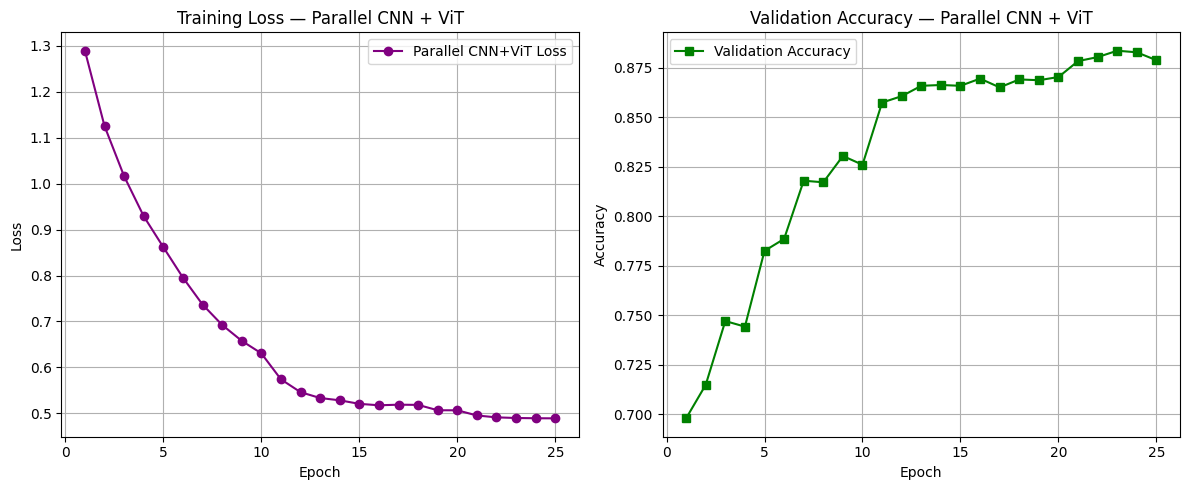

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(parallel_train_losses) + 1)

plt.figure(figsize=(12, 5))

# 📉 Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, parallel_train_losses, label='Parallel CNN+ViT Loss', marker='o', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss — Parallel CNN + ViT')
plt.legend()
plt.grid(True)

# 📈 Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, parallel_val_accs, label='Validation Accuracy', marker='s', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy — Parallel CNN + ViT')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


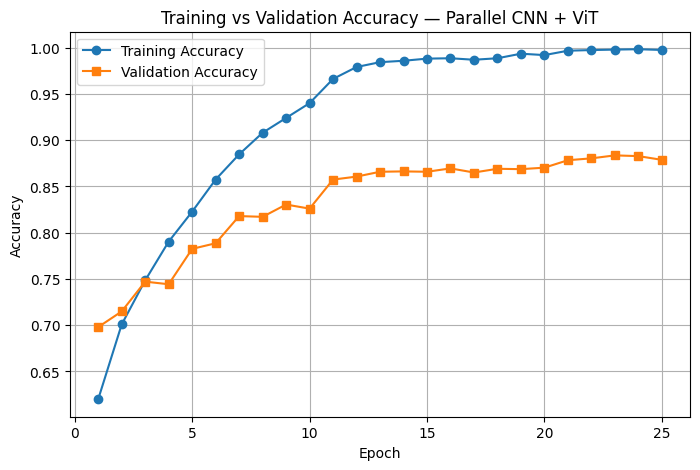

In [31]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy — Parallel CNN + ViT')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(parallel_train_accs, parallel_val_accs)

In [32]:
hybrid_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = hybrid_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = list(CLASS_MAP.keys())
print("📋 Classification Report — Sequential Hybrid CNN+ViT Model")
print(classification_report(all_labels, all_preds, target_names=class_names))


📋 Classification Report — Sequential Hybrid CNN+ViT Model
              precision    recall  f1-score   support

          AK       0.71      0.54      0.61       147
         BCC       0.85      0.86      0.86       562
         BKL       0.73      0.64      0.68       228
          DF       0.81      0.52      0.63        25
         MEL       0.78      0.84      0.81       572
          NV       0.83      0.88      0.85       841
         SCC       0.70      0.58      0.64        86
        VASC       0.84      0.73      0.78        22

    accuracy                           0.81      2483
   macro avg       0.78      0.70      0.73      2483
weighted avg       0.80      0.81      0.80      2483



In [33]:
from sklearn.metrics import confusion_matrix

def compute_sens_spec(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    for i in range(len(cm)):
        label = class_names[i] if class_names else f"Class {i}"
        print(f"{label}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

# Sensitivity and specificity
compute_sens_spec(all_labels, all_preds, class_names=list(CLASS_MAP.keys()))

Confusion Matrix:
 [[ 79  27  22   0  10   7   2   0]
 [ 12 483  11   1  12  36   5   2]
 [  8  14 145   0  20  31  10   0]
 [  0   3   0  13   4   5   0   0]
 [  5  13  12   0 478  62   1   1]
 [  2   7   6   1  84 738   3   0]
 [  5  19   3   1   3   5  50   0]
 [  0   0   0   0   4   2   0  16]]
AK: Sensitivity = 0.5374, Specificity = 0.9863
BCC: Sensitivity = 0.8594, Specificity = 0.9568
BKL: Sensitivity = 0.6360, Specificity = 0.9761
DF: Sensitivity = 0.5200, Specificity = 0.9988
MEL: Sensitivity = 0.8357, Specificity = 0.9283
NV: Sensitivity = 0.8775, Specificity = 0.9099
SCC: Sensitivity = 0.5814, Specificity = 0.9912
VASC: Sensitivity = 0.7273, Specificity = 0.9988
